# Regression and more on Bayesian Inference
### Course: Astroinformatics
### Profs: Valentino Gonzalez; Francisco Forster
### Author: Jose Vines
### Mail: jose.vines@ug.uchile.cl

In this demo we'll review regression and we'll do a bit more of bayesian inference, though we won't go into detail on the mathematics regarding regression, you can find it in [the course's notes](https://github.com/thevalentino/AS450-astroinformatica/blob/2020B/05-Linear%20Regression.ipynb)

Regression has multiple purposes. Perhaps you don't need to know the underlying distribution of you parameters, but a point estimate is enough, maybe you want to write an mcmc code but you're unsure on how to select the initial parameters for the chain or maybe you need to do feature selection on your model so you perform a lasso regression. 

In this notebook we'll review some methods to do regression, review some cases of regression in astronomy and finally perform linear regression and then bayesian inference on a photometry observation dataset in order to calibrate them.

In [1]:
import pymc3 as pm
print(f'Running PyMC3 v{pm.__version__}')
import scipy.optimize as op
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

Running PyMC3 v3.9.3


In [2]:
%matplotlib inline

A good basic method of regression is called the Chi Squared method, which is based on the statistics of the Chi squared function $$\chi^2 = \sum_i^N\left[ \frac{D_i - M_i(\hat{\theta})}{\sigma_i} \right]^2$$

Where $D_i$ are your individual measurements -- your data, $M_i(\hat{\theta})$ is your model corresponding to datapoint $D_i$ evaluated with a vector parameter $\hat{\theta}$, and $\sigma_i$ is your standard error on each measurement.

We can extend this function to the *reduced Chi squared* function, which is simply $\chi^2_\nu = \frac{\chi^2}{\nu}$ where $\nu = N - n$ are your problem's degrees of freedom, defined by the number of datapoints ($N$) and the number of parameters in your model ($n$).

The reason we define the reduced Chi squared is because it's generally a good indicator of *how good your fit is*, whith $\chi^2_\nu \sim 1$ being considered a good (or reasonably good, at least) fit, $\chi^2_\nu >> 1$ underfitting and $\chi^2_\nu << 1$ overfitting.

There are multiple methods for minimizing the Chi squared, in this demo we'll showcase the levenberg-marquadt approach which is readily implemented in the ```scipy.optimize``` module under the ```leastsq``` function. There are other minimization methods there, so I encourage you to [check the API](https://docs.scipy.org/doc/scipy/reference/optimize.html)

```leastsq``` recieves as parameters a callable function that calculates the vector of residuals, an x0 array with initial estimates for the parameters, and [other keywords](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq)

An important part of spectral analysis is the calculation of stellar parameters such as effective temperature, metallicity, log g, rotation, macro/micro turbulence. For some of these calculations it might be beneficial to model the absorption lines of the star. We're going to to just that, model the $H_\alpha$ absorption line of a rest-frame stellar spectrum obtained with the FEROS spectrograph mounted in the ESO/MPG 2.2-m telescope at La Silla

First let's start by loading and visualizing the spectra

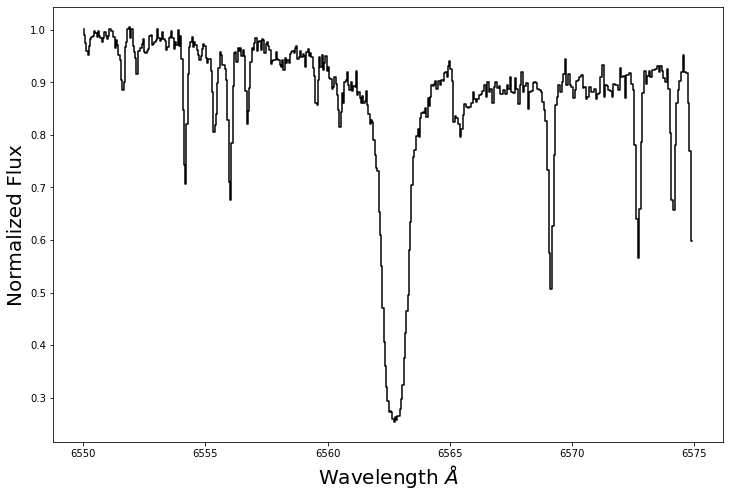

In [3]:
data = np.loadtxt('assets/halpha.dat')
wave = data[:, 0]
flux = data[:, 1]
fig, ax = plt.subplots(figsize=(12,8))
ax.step(wave, flux, color='k')
ax.set_xlabel(r'Wavelength $\AA$', fontsize=20)
ax.set_ylabel('Normalized Flux', fontsize=20);

Now we'll define our model. In this case we'll use a Gaussian profile plus an offset (though there are other options such as a lorentzian profile!). The gaussian function is defined by $$\mathcal{G}(x) = \gamma + A\exp\left\{-\left(\frac{x-\mu}{\sigma}\right)^2\right\}$$

Now we define our model:

In [4]:
def model(x, theta):
    """Our model. x is the wavelength and theta our parameter vector."""
    gamma = theta[0]
    A = theta[1]
    mu = theta[2]
    sigma = theta[3]
    return gamma + A * np.exp(-((x - mu) / sigma) ** 2)

No we need to come up with an estimate for the solution. We now beforehand that the $H_\alpha$ line is centered at $6562.808$ angstroms, we can also see that the amplitude of this line is $\sim  -0.6$ (we put a minus because it's an absorption line) and that the line is offset from 0 by $\sim 0.9$. For $\sigma$ we will go with 1

In [5]:
p0 = np.array([0.9, -0.6, 6562.808, 1])

Now we do the fit with ```scipy.optimize.leastsq```, for this, though, remember we need a function that returns the **residual vector**

In [6]:
def residuals(theta, x, y):
    return y - model(x, theta)

Now we can call ```scipy.optimize.leastsq```

In [7]:
res, flag = op.leastsq(residuals, p0, args=(wave, flux))
print(res)

[ 9.09399447e-01 -6.91015058e-01  6.56279160e+03  6.84762279e-01]


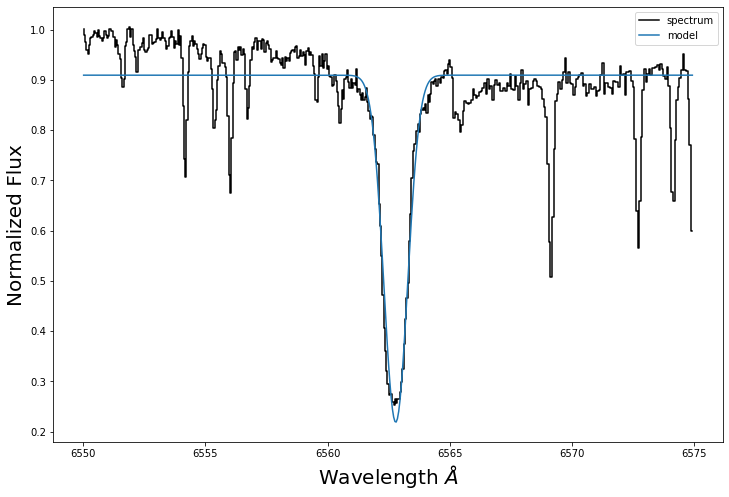

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.step(wave, flux, color='k', label='spectrum')
ax.plot(wave, model(wave, res), label='model')
ax.set_xlabel(r'Wavelength $\AA$', fontsize=20)
ax.set_ylabel('Normalized Flux', fontsize=20)
plt.legend(loc=0);

We can see this is an OK solution, though it can be improved. We'll leave this improvement to you! Try to fit a gaussian plus linear model now to take into account the slope. After that calculate the reduced chi squared of the gaussian plus offset versus the gaussian plus linear model. Which one is better?

We won't review lasso or ridge regression in detail here, but you can find implementations for them in [scikit-learn](https://scikit-learn.org/stable/index.html). Nevertheless, these kinds of regressions have important utilities in astronomy (and science in general!), see for example the [application of lasso regression on LIGO](https://arxiv.org/pdf/1807.02592.pdf)

Our next example using a different tool will be to perform photometric calibrations from observations made in the **g** and **r** bands with some telescope. The equation to calibrate the photometric magnitude is: $$g - g_{instr} =  a_g + b_g ((g - r) - (g - r)_0) + k_g * X$$

Where:
- $g_{instr}$ is the instrumental magnitude
- $a_g$ is the photometric zero point. 
- $b_g$ is the instrumental color term coefficient. 
- $(g - r)$ is the calibrated g-r color of the star, which is the same as the instrumental color.
- $(g - r)_0$ is a reference color, which we'll take to be 0.53
- $k_g$ is the first order extinction
- And $X$ is the airmass.

We wish to find $a_g$ and $b_g$

Our observations are in units of 'counts'. We can calculate the flux with the following equation: 

$$f = -2.5\log\left(\frac{c}{T}\right)$$

Where $c$ are the counts and $T$ the exposure time in seconds. In this exercise the exposure time is 3 seconds.

The data is in a file called 'observations.csv', which we'll read using pandas

In [9]:
df = pd.read_csv('assets/observations.csv')

Let's see how the data looks like

In [10]:
df

,STD,g_counts,r_counts,g_counts_e,X
0,15.867,13811.212650,26932.284140,81.727497,1.449966
1,15.716,15770.768590,30353.228710,85.795680,1.736940
2,15.919,13370.987400,28019.115060,80.787398,1.138535
3,16.113,11488.358450,26409.339530,76.877500,1.373901
4,15.212,25474.330070,51824.839540,104.489584,1.356806
5,15.051,30142.538910,64716.693750,112.210600,1.496144
6,16.187,10220.034010,18516.036780,74.015869,1.883707
7,17.043,4805.459219,14577.969930,59.105657,1.433115
8,16.921,5329.213994,10371.277330,60.649620,1.226045
9,16.625,7023.719714,19341.376800,66.010412,1.064928


First things first, our target data are labeled 'STD' and our observations are 'g_counts', 'r_counts', and 'X'. We'll ignore the uncertainty in the 'r_counts' and we'll only calibrate our observations in **g**. We'll do a linear regression to find the parameters we're interested in, and later we'll do a bayesian approach to the same problem.

We're going to assume the observations are normally distributed $g - g_{inst} \sim \mathcal{N}(\mu, \sigma^2)$ and we'll use flat priors for all parameters, except $\sigma$, for which we'll use a half normal distribution $\sigma \sim |\mathcal{N}(0, 0.01)|$

Before setting up our models, though, we need to take care of some astronomy things. Our data is in counts and not magnitudes! so first, we need to extract our observations and calculate the instrumental magnitudes.

In [11]:
# First we extract our data
g = df['STD']
g_counts = df['g_counts']
r_counts = df['r_counts']
g_counts_e = df['g_counts_e']
airmass = df['X']
# We said our exposure time was 3 seconds and that our reference color is 0.53
texp = 3
g_r_0 = 0.53

Here we define some basic functions to calculate magnitudes and their errors.

In [12]:
def instrumental_mag(c, t):
    """Calculate the instrumental magnitude.
    
    c is the counts and t the exposure time in seconds.
    """
    f = -2.5 * np.log10(c / t)
    return f

def instrumental_mag_err(c, dc):
    """Calculate the error in the instrumental magnitude.

    c is the counts and dc is the uncertainty in the counts.
    """
    return np.sqrt((2.5 * dc / c / np.log(10))**2)

In [13]:
g_inst = instrumental_mag(g_counts, texp)
g_inst_e = instrumental_mag_err(g_counts, g_counts_e)
r_inst = instrumental_mag(r_counts, texp)
g_r = g_inst - r_inst
obs = g - g_inst

Let's visualize our data first, to see what we're dealing with

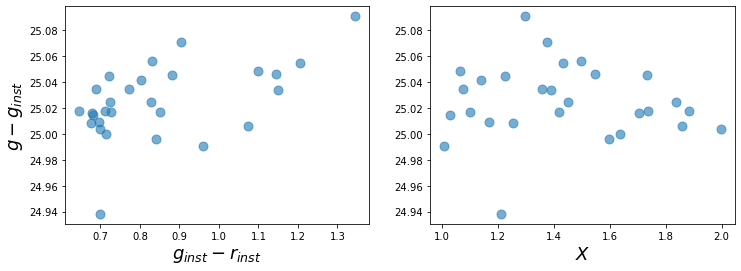

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(g_r, obs, alpha=0.6, s=80)
axes[1].scatter(airmass, obs, alpha=0.6, s=80)
axes[0].set_xlabel(r'$g_{inst} - r_{inst}$', fontsize=18)
axes[1].set_xlabel(r'$X$', fontsize=18)
axes[0].set_ylabel(r'$g - g_{inst}$', fontsize=18);

Now we can set up our model

In [15]:
with pm.Model() as model:
    b = pm.Uniform('b', 0, 1)
    a = pm.Uniform('a', 20, 30)
    k = pm.Uniform('k', -1, 1)
    sigma = pm.HalfNormal('sigma', sigma=0.01)
    
    # Our model goes here
    mod = a + b * (g_r - g_r_0) + k * airmass
    
    # The likelihood
    g_ginst = pm.Normal('Obs', mu=mod, sigma=sigma, observed=obs)

Now we'll do a maximum a posteriori estimate for the model

In [16]:
map_estimate = pm.find_MAP(model=model)
map_estimate

{'b_interval__': array(-2.45635855),
 'a_interval__': array(0.00179558),
 'k_interval__': array(-0.00629151),
 'sigma_log__': array(-3.80523413),
 'b': array(0.0789748),
 'a': array(25.00448895),
 'k': array(-0.00314574),
 'sigma': array(0.02225399)}

Now we'll take a bayesian approach!

After reading the literature, we found that the means of the parameters are $a = 25 \pm 0.05$, $b = -0.10 \pm 0.02$ and $k = 0.2 \pm 0.02$

We are going to use this information as priors for our calibration.

In [17]:
with pm.Model() as model:
    b = pm.Normal('b', -0.1, 0.02)
    a = pm.Normal('a', 25, 0.05)
    k = pm.Normal('k', 0.2, 0.02)
    sigma = pm.HalfNormal('sigma', sigma=0.01)
    
    # Our model goes here
    mod = a + b * (g_r - g_r_0) + k * airmass
    
    # The likelihood
    g_ginst = pm.Normal('Obs', mu=mod, sigma=sigma, observed=obs)
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.885101502863413, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


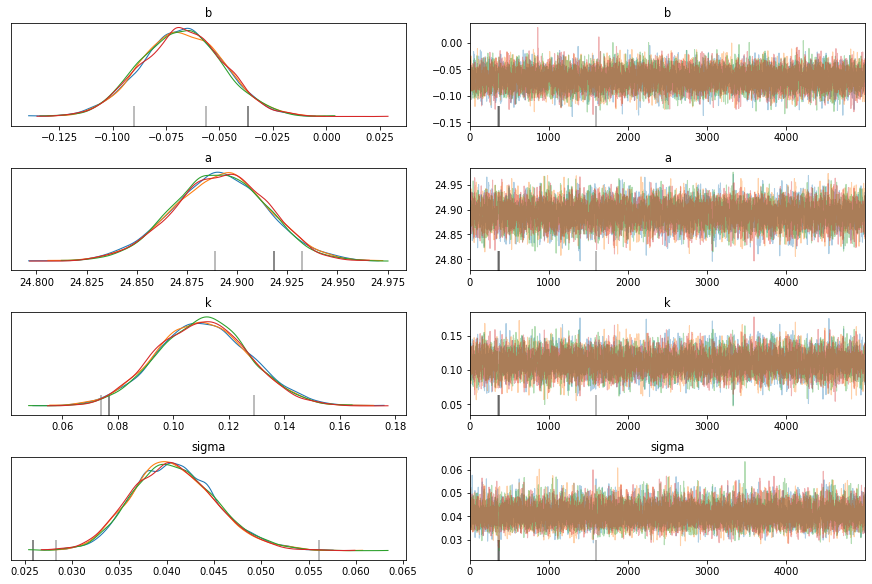

In [18]:
az.plot_trace(trace);

In [19]:
b_m = trace['b'].mean()
a_m = trace['a'].mean()
k_m = trace['k'].mean()
print(f'b = {b_m}, a = {a_m}, k = {k_m}')


b = -0.06764516784672803, a = 24.89133724054598, k = 0.11057679003254622


Now we can compare to our values from the MAP and see the effects on modeling with informative priors!